<a href="https://colab.research.google.com/github/osama629/finalproject/blob/main/vgg16_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten


<ipython-input-2-36398ed231ac>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Step 1: Set the correct dataset path
dataset_path = '/content/drive/MyDrive/dataset'  # This is the path to the dataset folder

# Step 2: Initialize arrays for storing images and labels
X = []
y = []

# Define the classes (assuming four types of eye diseases)
classes = ['cataract', 'glaucoma', 'normal', 'diabetic_retinopathy']

# Step 3: Loop through each class folder and load images
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)  # Path to each class folder (inside /dataset/)

    for img_name in tqdm(os.listdir(class_path)):  # List all image files in the class folder
        img_path = os.path.join(class_path, img_name)  # Full path to the image
        img = cv2.imread(img_path)  # Read the image

        if img is not None:  # Make sure the image is loaded correctly
            img = cv2.resize(img, (224, 224))  # Resize to VGG16 input size
            X.append(img)  # Add the image to the list
            y.append(i)  # Use class index as label

# Step 4: Convert to NumPy arrays for model input
X = np.array(X)
y = np.array(y)

# Display the shape of X and y
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]} and {y.shape[0]} labels.")


100%|██████████| 1105/1105 [00:32<00:00, 33.56it/s] 


Loaded 4224 images with shape (224, 224, 3) and 4224 labels.


In [4]:
from keras.applications import vgg16

# Correct path to your weights file
weights_path = '/content/drive/MyDrive/model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the VGG16 model with ImageNet weights from the local path
vgg = vgg16.VGG16(weights=weights_path,
                  include_top=False,
                  input_shape=(224, 224, 3))


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# One-hot encode the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)


X_train Shape:  (2830, 224, 224, 3)
X_test Shape:  (1394, 224, 224, 3)
y_train Shape:  (2830, 4)
y_test Shape:  (1394, 4)


In [6]:
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Load the VGG16 model with weights from your local path
vgg = vgg16.VGG16(weights='/content/drive/MyDrive/model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False, input_shape=(224, 224, 3))

# Freeze all VGG16 layers
for layer in vgg.layers[10:]:
    layer.trainable = False

# Add custom classification layers on top
def add_custom_layers(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)  # 4 classes for eye diseases
    return top_model

# Define the number of classes
num_classes = 4  # Four types of eye diseases

# Add the custom layers on top of VGG16
FC_Head = add_custom_layers(vgg, num_classes)

# Create the final model
model = Model(inputs=vgg.input, outputs=FC_Head)

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 16,816,452 (64.15 MB)

 Trainable params: 3,837,252 (14.64 MB)

 Non-trainable params: 12,979,200 (49.51 MB)

None


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# raiTn the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.3822 - loss: 1.4676 - val_accuracy: 0.5524 - val_loss: 0.9407
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 466ms/step - accuracy: 0.5913 - loss: 0.8541 - val_accuracy: 0.6693 - val_loss: 0.7521
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 85s 502ms/step - accuracy: 0.6679 - loss: 0.7122 - val_accuracy: 0.7253 - val_loss: 0.6462
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 503ms/step - accuracy: 0.6885 - loss: 0.7143 - val_accuracy: 0.7188 - val_loss: 0.6357
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 79s 465ms/step - accuracy: 0.7246 - loss: 0.5984 - val_accuracy: 0.6944 - val_loss: 0.6997
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 464ms/step - accuracy: 0.7391 - loss: 0.5874 - val_accuracy: 0.7403 - val_loss: 0.5822
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 85s 502ms/step - accuracy: 0.7395 - loss: 0.5746 - val_accuracy: 0.7339 - val_loss: 0.5924
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 502ms/step - accuracy: 0.7549 - loss: 0.5584 - val_accura

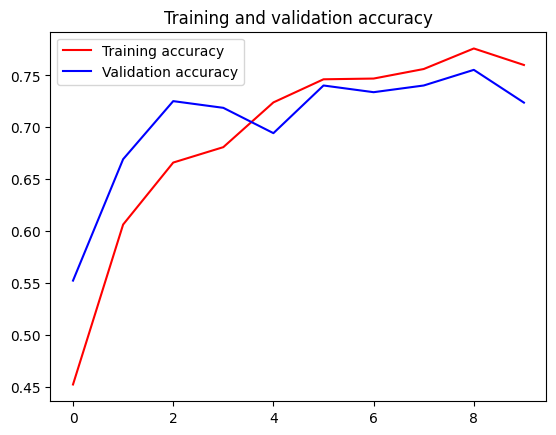

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np


In [10]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels (one-hot encoded to class labels)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step


In [11]:
# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print the classification report for a more detailed overview
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))

# Print accuracy, precision, recall, and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Classification Report:
                       precision    recall  f1-score   support

            cataract       0.67      0.67      0.67       352
            glaucoma       0.60      0.38      0.46       342
              normal       0.64      0.94      0.76       342
diabetic_retinopathy       1.00      0.91      0.95       358

            accuracy                           0.72      1394
           macro avg       0.73      0.72      0.71      1394
        weighted avg       0.73      0.72      0.71      1394

Confusion Matrix:
 [[236  33  83   0]
 [115 129  98   0]
 [  1  20 320   1]
 [  0  33   1 324]]
Accuracy: 0.7238
Precision: 0.7289
Recall: 0.7238
F1 Score: 0.7126


In [12]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_true_classes and y_pred_classes are your true and predicted labels, and classes is a list of class names

# Calculate overall accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1 score per class (weighted)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print classification report (shows precision, recall, and F1 for each class)
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))

# Print overall accuracy, precision, recall, and F1 score
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

# Accuracy per class (from confusion matrix)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy for each class
for i, class_name in enumerate(classes):
    print(f"Accuracy for {class_name}: {class_accuracy[i]:.4f}")


Classification Report:
                       precision    recall  f1-score   support

            cataract       0.67      0.67      0.67       352
            glaucoma       0.60      0.38      0.46       342
              normal       0.64      0.94      0.76       342
diabetic_retinopathy       1.00      0.91      0.95       358

            accuracy                           0.72      1394
           macro avg       0.73      0.72      0.71      1394
        weighted avg       0.73      0.72      0.71      1394

Confusion Matrix:
 [[236  33  83   0]
 [115 129  98   0]
 [  1  20 320   1]
 [  0  33   1 324]]
Overall Accuracy: 0.7238
Weighted Precision: 0.7289
Weighted Recall: 0.7238
Weighted F1 Score: 0.7126
Accuracy for cataract: 0.6705
Accuracy for glaucoma: 0.3772
Accuracy for normal: 0.9357
Accuracy for diabetic_retinopathy: 0.9050


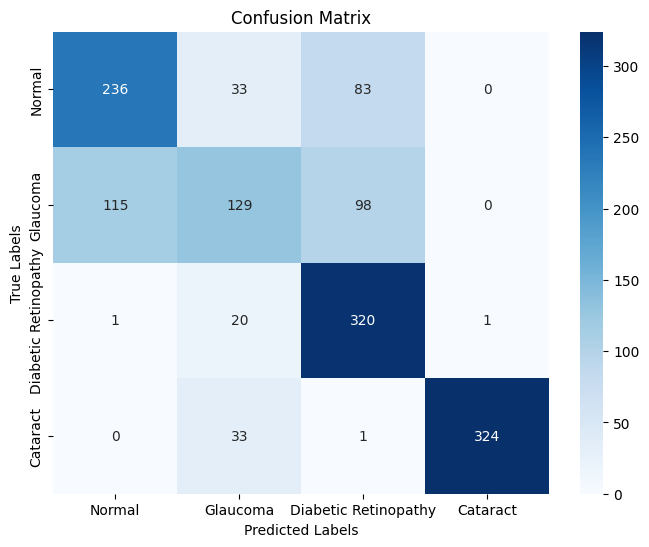

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class names
classes = ['Normal', 'Glaucoma', 'Diabetic Retinopathy', 'Cataract']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

# Add labels, title, and formatting
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
